### Импортируем необходимые библиотеки для работы с данными 

In [1]:
import pandas as pd
import pandahouse as ph
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

#параметры соединения - нужны, чтобы подключиться к нужной схеме данных
connection = {'host': 'https://clickhouse.lab.karpov.courses',
'database':'simulator_20250220',
'user':'student',
'password':'dpo_python_2020'
}

#текст запроса
query = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2025-01-31' and '2025-02-06'
    and exp_group in (2,1)
GROUP BY exp_group, user_id
"""

# эта функция выполнит запрос и запишет его результат в pandas DataFrame
df = ph.read_clickhouse(query, connection=connection)

In [2]:
df.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,39,141,0.276596
4,1,18392,7,32,0.218750


In [3]:
# Проверим , что в группах примерно одинаковое количество пользователей
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
1,10020,10020,10020,10020
2,9877,9877,9877,9877


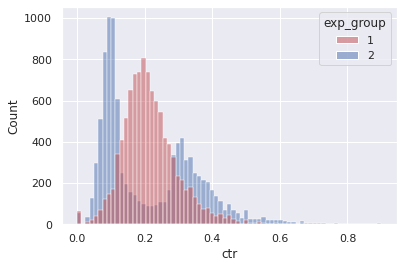

In [4]:
# Посмотрим как выглядят наши распределения
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

## Сформулируем нулевую и альтернативную гипотезы для проведения t-теста:
- H0 - разницы в средних CTR в 1 и 2 группах нет;
- H1 - разница в средних CTR в 1 и 2 группах есть.

In [5]:
t_stat, p_val = stats.ttest_ind(df[df['exp_group'] == 1].ctr, df[df['exp_group'] == 2].ctr, equal_var=False)
print(f'Результаты t-теста: Т-статистика = {t_stat}, p-value = {p_val}')

Результаты t-теста: Т-статистика = 0.4051491913112757, p-value = 0.685373331140751


В результате оценки результатов А/B - теста при помощи t-критерия Стьюдента мы получили `p-value = 0.68`, что больше чем 0.05 и можем сказать , что у нас недостаточно оснований , чтобы отклонить нулевую гипотезу о равенстве средних CTR в группах 1 и 2 , а значит статистически значимых различий в средних CTR нет, что , кстати, не совсем объясняет график распределений CTR обеих групп! Распределение CTR контрольноц группы имеет бимодальный характер, а t-тест не учитывает разницу в распределениях контрольной и тестовой группы, а просто оценивает разницу в средних значениях!

## Сформулируем нулевую и альтернативную гипотеезы для проведения теста Манна-Уитни:
- H0 - P(X>Y) = P(Y>X), то есть данные в 1 и 2 группах взяты из одного распределения;
- H1 - P(X>Y) != P(Y>X), то есть данные в 1 и 2 группах взяты из разных распределений.

In [6]:
u_stat, p_val = stats.mannwhitneyu(df[df['exp_group'] == 1].ctr, df[df['exp_group'] == 2].ctr, alternative='two-sided')
print(f'Результаты теста Манна-Уитни: U-статистика = {u_stat}, p-value = {p_val}')

Результаты теста Манна-Уитни: U-статистика = 55189913.0, p-value = 4.632205841806026e-45


Как мы видим тест Манна-Уитни таки прокрасился и мы получили `p-value = 4.632205841806026e-45`, что сильно меньше 0.05 , а это означает, что мы можем отвергнуть нулевую гипотезу и сказать что CTR в группах 1 и 2 взяты из разных распределений, что мы, как раз таки и видели на гистограмме распределений 1 и 2 групп!

## Так как мы поняли , что у нас данные из разных распределений , попробуем поработать со сглаженным CTR и сформулируем нулевую и альтернативную гипотеезы для проведения t-теста на сглаженных CTR:
- H0 - разницы в сглаженных средних CTR в 1 и 2 группах нет;
- H1 - разница в сглаженных средних CTR в 1 и 2 группах есть.

In [7]:
# Функция для расчёта сглаженного CTR
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [8]:
global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

/tmp/ipykernel_100/2181465673.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(group2.ctr,


<Axes: xlabel='ctr'>

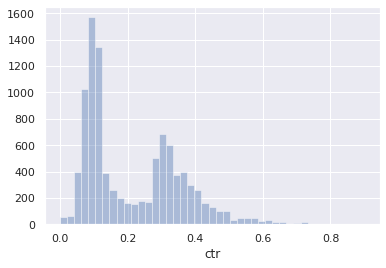

In [9]:
# Посмотрим как выглядел CTR именно тестовой группы до сглаживания
group1 = df[df.exp_group == 1].copy()
group2 = df[df.exp_group == 2].copy()
sns.distplot(group2.ctr, 
             kde = False)

/tmp/ipykernel_100/2795933523.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(group2.smothed_ctr,


<Axes: xlabel='smothed_ctr'>

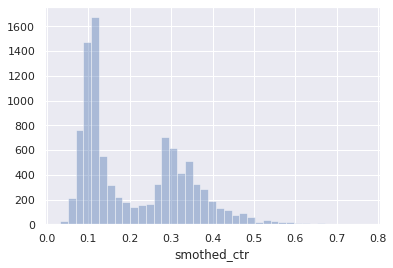

In [10]:
group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)
group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

sns.distplot(group2.smothed_ctr, 
             kde = False)

In [11]:
t_stat, p_val = stats.ttest_ind(group1.smothed_ctr, group2.smothed_ctr, equal_var=False)
print(f'Результаты t-теста: Т-статистика = {t_stat}, p-value = {p_val}')

Результаты t-теста: Т-статистика = 1.9460491517027683, p-value = 0.05166679015318526


В результате проведения t-теста на сглаженных CTR , мы видим , что на этот раз `p-value = 0.0516`, что уже гораздо ближе к заветным 0.05, но всё же больше порога значимости, а это означает , что в данном тесте у нас недостаточно оснований , чтобы отвергнуть нулевую гипотезу и средний CTR в группах 1 и 2 статистически значимо не отличается! Так же, не забываем , что в тесте со сглаженным CTR мы используем гиперпараметр `alpha = 5`, что не гарантирует нам корректные результаты из-за отсутсвия гарантии в однонаправленности сглаженного CTR и общего количества кликов. 

Что же, мы посмотрели на статистическую значимость в отличиях средних CTR в группах, теперь мы хотим проанализировать отличия общего CTR в группах 1 и 2! Для это нам необходимо нагенерировать подвыборок, в каждой из которых мы будем считать глобальный CTR в контрольной и тестовой группе, а затем сравнивать изменения в глобальных CTR! Для этого воспользуемся Пуассоновским бутстрапом! 
## Сформулируем нулевую и альтернативную гипотезы для проведения Пуассоновского бутстрапа! 
- H0 - разницы в глобальных CTR в 1 и 2 группах нет;
- H1 - разница в глобальных CTR в 1 и 2 группах есть.

<Axes: ylabel='Count'>

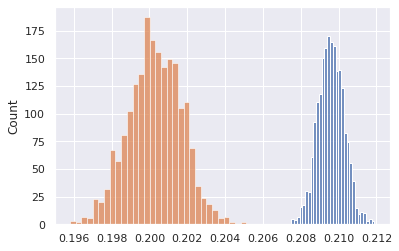

In [12]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2


likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1)
sns.histplot(ctr2)

<Axes: ylabel='Count'>

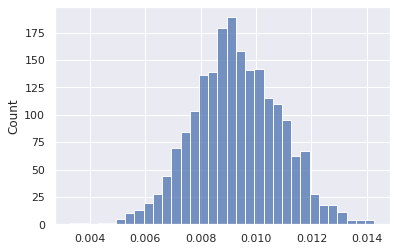

In [13]:
#Разница между глобальными CTR
sns.histplot(ctr1 - ctr2)

Итак , распределение разниц между глобальными CTR не включает в себя 0 на оси X , а это означает , что мы получили статистически значимые различия в группах, причём глобальный CTR 1й или контрольной группы, оказался статистически значимо больше глобального CTR 2й или тестовой группы!

## Ну и проведём исследование изменений в CTR поверх бакетного преобразования с помощью тестов Манна-Уитни и t-тест!

In [14]:
q = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2025-01-31' and '2025-02-06'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df = ph.read_clickhouse(q, connection=connection)

In [15]:
#тест Манна-Уитни видит отличие
stats.mannwhitneyu(df[df.exp_group == 1].bucket_ctr, 
                   df[df.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1997.0, pvalue=2.6576427804010095e-07)

In [16]:
#и t-тест тоже
stats.ttest_ind(df[df.exp_group == 1].bucket_ctr, 
                   df[df.exp_group == 2].bucket_ctr, 
                   equal_var = False)

Ttest_indResult(statistic=5.614819358149381, pvalue=4.592644937473873e-07)

<Axes: xlabel='bucket_ctr', ylabel='Count'>

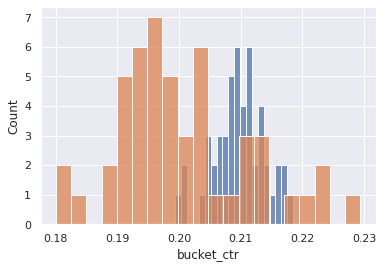

In [17]:
# Распределения бакетных CTR c натяжкой похоже на нормальное (в контрольной группе)
sns.histplot(df[df.exp_group == 1].bucket_ctr, bins=20)
sns.histplot(df[df.exp_group == 2].bucket_ctr, bins=20)

## Выводы:

1. Сразу хочется оговориться, что данное исследование ярко демонстрирует такую проблему в А/B - тестировании как попарное сравнение, то есть использование или перебор разных тестов! Мы видим , что некоторые из них прокрасились, а некоторые нет! И как же делать вывод? По идее, когда мы имеем дело, с попарными сравнениями, мы должны вносить поправки в уровень значимости, то есть , грубо говоря, кратно количеству используемых тестов, уменьшить порог значимости! Иначе получилось бы исследование, в котором мы как бы "охотимся" за желаемым результатом и ищем нужный нам p-value, а это недопустимо, если мы не хотим сильно завысить вероятность ошибки 1-го рода! Но это не про данный урок, по этому идём дальше!
2. Что касается нашего конкретного исследования CTR, то так как по условия задания основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR! Не среднего CTR в группе, а глобального CTR 2-й группы! Таким образом, я буду обращать внимание на тесты Пуассоновский бутстрап и тесты поверх бакетного преобразования, потому как именно они дают нам результаты изменений в глобальном CTR между группами! 
3. И Пуассоновский бутстрап, и тесты Манна-Уитни и t-тест поверх бакетного преобразования , показали статистически значимые различия в глобальных CTR в группах, но также они показали , что глобальный CTR в группе 1 , или контрольной, выше чем CTR в группе 2 , или тестовой! Следовательно я дам рекомендации о том, что изменения, которые были применены к группе 2 не стоит выкатывать в прод!